# Diffusion-TS Tutorial

## Diffusion-TS: Interpretable Diffusion for General Time Series Generation

This notebook describes the user-guide of a time-series synthetic data generation application using Diffusion-TS framework.

## Necessary packages and functions call

In [3]:
import os
import torch
import numpy as np
import pandas as pd

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

In [17]:
imputated_data = np.load("./OUTPUT/full_econ/ddpm_fake_full_econ.npy")
gt_12 = np.load("./OUTPUT/full_econ/samples/macroecon_missing_ground_truth_12_train.npy")
# imputated_data_mask = np.load("./OUTPUT/toy_econ/samples/macroecon_missing_masking_24.npy")
# imputated_data_gt_test = np.load("./OUTPUT/toy_econ/samples/macroecon_missing_ground_truth_24_test.npy")

# gt_24 = np.load("./OUTPUT/econ/samples/macroeconomic_ground_truth_24_train.npy")
# original_missing_data = pd.read_csv("/home/vincentwork/Diffusion-TS/Data/datasets/diffusion.csv", na_values=['', ' '])
# Check for missing values
# print(original_missing_data)

In [ ]:
fp = "./Data/datasets/unemployment.csv"
df = pd.read_csv(fp)
df = df.drop("observation_date", axis=1)
df.to_csv(fp, index=False)

## Setting and Training

### Build dataset and settings

In [ ]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/unemploy.yaml'
        self.save_dir = './OUTPUT/unemploy'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')
print(device)
dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

cuda:0


### Training models

In [10]:
trainer.train()

loss: 0.129219: 100%|██████████| 10000/10000 [18:23<00:00,  9.06it/s]

training complete


## Inference and Visualizations

### Sampling

In [12]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
ori_data = np.load(os.path.join(dataset.dir, f"unemploy_missing_ground_truth_{seq_length}_train.npy"))
# ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_train.npy"))  # Uncomment the line if dataset other than Sine is used.
fake_data = trainer.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_unemploy.npy'), fake_data)

sampling loop time step: 100%|██████████| 500/500 [00:06<00:00, 71.94it/s]


### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

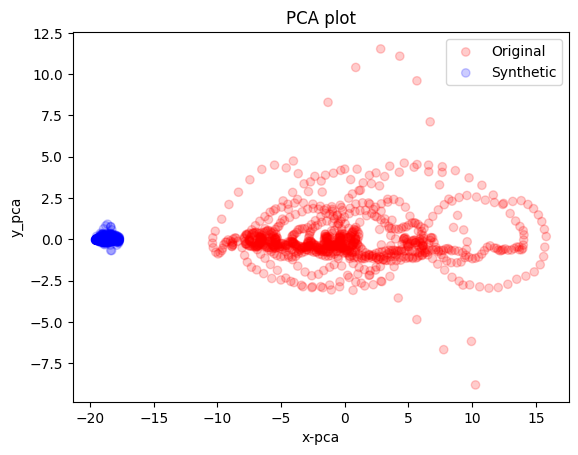

In [13]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])

/home/czhao/multimodal/Diffusion-TS/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1826 samples in 0.004s...
[t-SNE] Computed neighbors for 1826 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1826
[t-SNE] Computed conditional probabilities for sample 1826 / 1826
[t-SNE] Mean sigma: 0.049564
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.307209
[t-SNE] KL divergence after 300 iterations: 0.922245


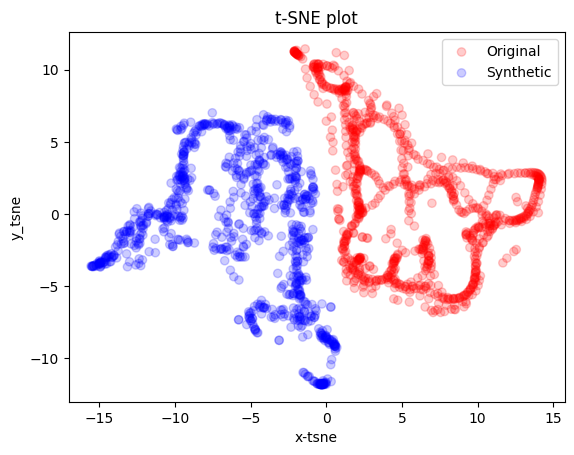

In [14]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])

/home/czhao/multimodal/Diffusion-TS/Utils/metric_utils.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/home/czhao/multimodal/Diffusion-TS/Utils/metric_utils.py:158: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

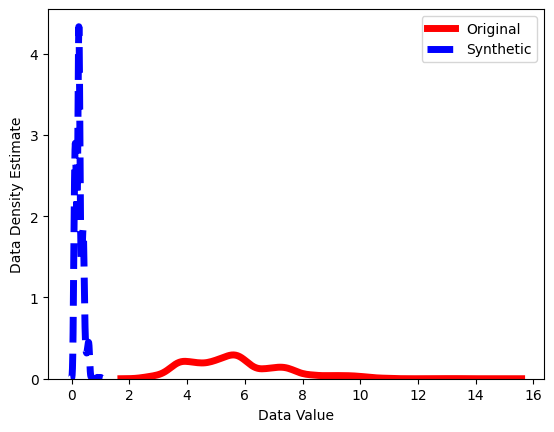

In [15]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])